# Anomaly Detection and Recommender Systems

## 1 Anomaly detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset $x^{(1)}, x^{(2)},..., x^{(m)}$. You suspect that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset. 

You will use a Gaussian model to detect anomalous examples in your dataset.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# load data
from scipy.io import loadmat

data = loadmat('ex8data1.mat')

X = data['X']
Xval = data['Xval']
yval = data['yval']

In [16]:
def plotData(X):
    """ plot training sample X
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(X[:, 0], X[:, 1], 'bx')
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Throughput (MB/s)')
    ax.set_aspect('equal')
    
    return fig, ax

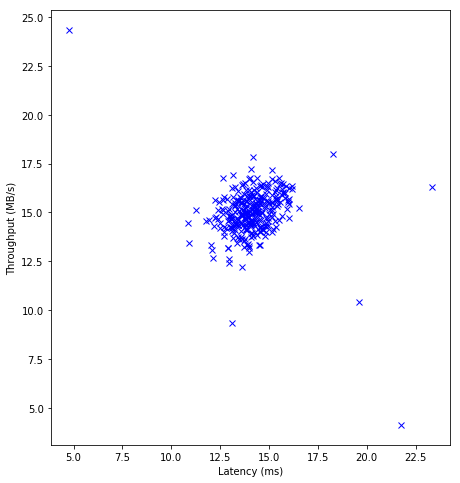

In [17]:
# Visualizing training samples
fig, ax = plotData(X)

### 1.1 Gaussian distribution

Given a training set ${x^{(1)}, x^{(2)},..., x^{(m)}}$ where $x^{(i)}\in \mathbb R^n$, we will fit each of the features $x^{(i)}$ into a Gasussian distribution. The Gaussian distribution is given by:

$$ p(x;\mu, \sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

where $\mu$ is the mean and $\sigma^2$ is the variance. 

### 1.2 Estimating parameters for a Gaussian distribution

The parameters, $(\mu_i, \sigma_i^2)$, of the i-th feature can be estimated by the following equation:

$$ \mu_i = \frac{1}{m}\sum_{j=1}^{m} x_i^{(j)}$$

$$ \sigma_i^2 = \frac{1}{m}\sum_{j=1}^{m} (x_i^{(j)} - \mu_i)^2 $$

In [18]:
def estimateGaussian(X):
    """ estimates the parameters of a 
%Gaussian distribution using the data in X
    """
    
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)   # degree of freedom is m (number of samples)
    
    return mu, sigma2

In [19]:
mu, sigma2 = estimateGaussian(X)
print(mu.shape)
print(sigma2.shape)

(2,)
(2,)


### 1.3 Probability density function for Multivariate Gaussian Distribution

The Probability density function for Multivariate Gaussian Distribution is given by: 

$$ p(x;\mu, \Sigma)=\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp\left(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)\right)$$

where $\Sigma$ is covariance matrix. Here, when we only consider distributions that are independent with each other, $\Sigma$ becomes a diagonal matrix with variances on the diagonal axis:

$$ \Sigma = \left[ \matrix{\sigma_1^2 & 0 & ...\cr 0 & \sigma_2^2 & ... \cr ...&...&...}\right]$$

$x$ and $\mu$ are vectors belongs to $\mathbb R^n$. 

To use X, where each row in X represents an sample point $x$, in the above vectorized equation, need to used a revised version: 

$$ p(X;\mu, \Sigma)=diag\left(\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp\left(-\frac{1}{2}(X-\mu) \Sigma^{-1}(X-\mu)^T\right)\right)$$

The result p will be a m-element array, containing probability density for each of the m points.

In [20]:
def multivariateGaussian(X, mu, sigma2):
    """ Computes the probability density function of the
%multivariate gaussian distribution
    """
    # num of variables
    n = len(mu)
    
    # construct diagonal matrix - the covariance matrix
    Sigma = np.diag(sigma2)
    Sigma_inv = np.diag(1/sigma2)
    
    # compute multivariate Gaussian probability density
    P =  np.exp(-0.5*(X-mu)@Sigma_inv@(X-mu).T) / ((2*np.pi)**(n/2)*(np.linalg.det(Sigma)**0.5))
    
    # extract diagonal from matrix P
    p = np.diag(P)
    
    return p    

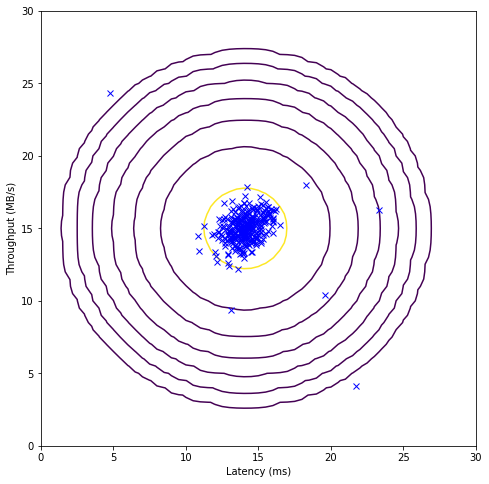

In [21]:
# Visualizing training samples
fig, ax = plotData(X)

# visualizing Gaussian model
delta = 0.5
x = np.arange(0, 35, delta)
y = np.arange(0, 35, delta)
X0, X1 = np.meshgrid(x, y)

# format matrix to input to multivariateGaussian() function
# critical step!!!!!!!!!
input_X = np.vstack((X0.ravel(), X1.ravel())).T
p = multivariateGaussian(input_X, mu, sigma2)

# convert back to size of meshgrid
Z = p.reshape(X0.shape)

#Z = np.exp(-(X0-mu[0])**2/(2*sigma2[0]))/np.sqrt(2*np.pi*sigma2[0]) * np.exp(-(X1-mu[1])**2/(2*sigma2[1]))/np.sqrt(2*np.pi*sigma2[1])

levels = np.logspace(-20, -2, 7)
ax.contour(X0, X1, Z, levels)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_aspect('equal')

### 1.3 Selecting the threshold

Threshold is used to determine if an sample is an anomaly or not. If $p(x) \lt \epsilon$, it is considered to be an anomaly (positive example, i.e. $y=1$).

In this part, we will use cross validation set as evaluation data and $F_1$ score as evaluation metric select optimum threshold. The $F_1$ score is computed using precision (prec) and recall(rec):

$$ F_1 = \frac{2\times prec\times rec}{prec+rec}$$

Precision is the ratio of correct prediction among all samples that you predict 'positive'; recall is the ratio of correct prediction among all samples that are truly positive. 

Precision and recall are computed by: 
$$ prec = \frac{tp}{tp+fp}$$
$$ rec = \frac{tp}{tp+fn}$$

where tp, fp, fn are the number of true positives, false positives, false negatives, respectively. 

In [22]:
def selectThreshold(yval, pval):
    """ Find the best threshold (epsilon) to use for selecting
%outliers
    """
    
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
        
    for epsilon in np.linspace(np.min(pval), np.max(pval), 1000):
        
        # predicted y based on epsilon
        ypre = np.zeros(yval.shape)
        ypre[pval < epsilon] = 1
        
        # prepare for tp, fp and fn calculation
        s = yval + ypre
        d = yval - ypre
        
        # compute tp, fp and fn
        tp = np.sum(s==2) # total number of cases where yval=ypre=1
        fp = np.sum(d==-1) # total number of cases where yval=0, ypre=1
        fn = np.sum(d==1) # total number of cases where yval=1, ypre=0
        
        # avoid division by zero
        if (tp+fp) != 0 and (tp+fn) != 0:
            # compute precision and recall
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
        
            # compute F1
            F1 = 2 * prec * rec / (prec + rec)
        else:
            F1 = 0
        
#         # debugging
#         F1_history[i] = F1
#         i += 1
        
        # update best Epsilon
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
        
    return bestEpsilon, bestF1

In [23]:
# test
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print("Epsilon: {}; F1: {:.3f}".format(epsilon, F1))
print("Expected Epsilon: 8.99e-05, F1: 0.875")

p = multivariateGaussian(X, mu, sigma2)
outliers = p < epsilon
print("Number of outliers is {}".format(np.sum(outliers)))

Epsilon: 8.999852631901397e-05; F1: 0.875
Expected Epsilon: 8.99e-05, F1: 0.875
Number of outliers is 6


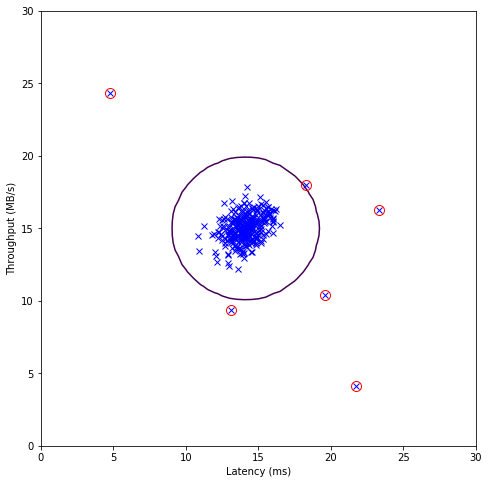

In [24]:
# visualization
# Visualizing training samples
fig, ax = plotData(X)

# visualizing Gaussian model
delta = 0.5
x = np.arange(0, 35, delta)
y = np.arange(0, 35, delta)
X0, X1 = np.meshgrid(x, y)

# format matrix to input to multivariateGaussian() function
# critical step!!!!!!!!!
input_X = np.vstack((X0.ravel(), X1.ravel())).T
p = multivariateGaussian(input_X, mu, sigma2)

# convert back to size of meshgrid
Z = p.reshape(X0.shape)

ax.contour(X0, X1, Z, levels=[epsilon])
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_aspect('equal')

# highlight outliers
ax.plot(X[outliers, 0], X[outliers, 1], 'ro', markersize=10, fillstyle='none')

### 1.4 High dimensional dataset

In [25]:
# test on high dimensional dataset
data2 = loadmat('ex8data2.mat')

X = data2['X']
Xval = data2['Xval']
yval = data2['yval']

# compute Gaussian model
mu, sigma2 = estimateGaussian(X)

# get probability for sample points in X
p = multivariateGaussian(X, mu, sigma2)

# probabilities for cross validation samples
pval = multivariateGaussian(Xval, mu, sigma2)

# optimize choice of epsilon
epsilon, F1 = selectThreshold(yval, pval)

# print results and compare
print("Epsilon: {}; F1: {:.3f}".format(epsilon, F1))
print("Expected Epsilon: 1.38e-18, F1: 0.615385")

print("Number of outliers: {}".format(np.sum(p < epsilon)))
print("Expected number of outliers: 117")

Epsilon: 1.3786074982000246e-18; F1: 0.615
Expected Epsilon: 1.38e-18, F1: 0.615385
Number of outliers: 117
Expected number of outliers: 117


## 2 Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.2 This dataset consists of ratings on a scale of 1 to 5. The dataset has nu = 943 users, and
nm = 1682 movies. 

### 2.1 Movie rating dataset

The matrix Y (a $num_movies \times num_users$ matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix R is an binary-valued indicator matrix, where $R(i,j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i; j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user. 



In [26]:
# load data
data = loadmat('ex8_movies.mat')

"""
%  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
%  943 users
%
%  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
%  rating to movie i
"""

Y = data['Y']
R = data['R']

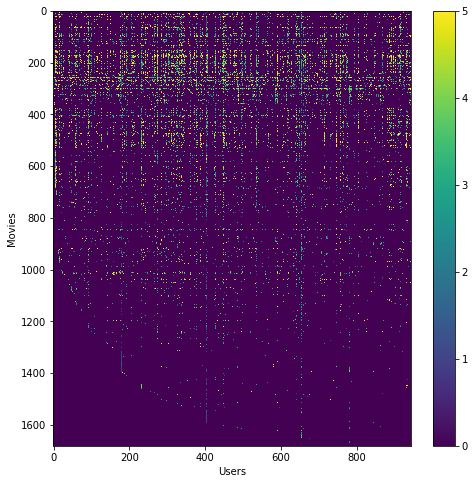

In [27]:
# Simple visualization
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
ax.set_aspect('auto')
fig.colorbar(im)

### 2.2 Collaborative filtering learning algorithm

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, ..., x^{(n_m)}$ and $\theta^{(1)}, ..., \theta^{(n_u)}$, where the model predicts the rating for movie i by user j as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}$ that produce the best fit (minimizes the squared
error).

#### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by: 
$$ J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)})=
\frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2 $$


With regularization terms, the equation becomes:

$$ J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)})=
\frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2 +
\left(\frac{\lambda}{2}\sum_{n_u}^{j=1}\sum_{n}^{k=1}(\theta_k^{(j)})^2\right) +
\left(\frac{\lambda}{2}\sum_{n_m}^{i=1}\sum_{n}^{k=1}(x_k^{(i)})^2\right)
$$

Considering that $X$ is of size $n_m \times n$ and $\Theta$ is of size $n_u \times n$, the vectorized cost function (without regularization) is given by: 

$$ J=\frac{1}{2} sum((X\Theta^T - Y).*(X\Theta^T - Y) .* (R==1)) + \frac{\lambda}{2}(sum(\Theta.*\Theta)+sum(X.*X))$$






#### 2.2.2 Collaborative filtering gradient

The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})\theta_k^{(j)}+\lambda x_k^{(i)}$$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(i)}+\lambda \theta_k^{(j)}$$

Note that $\frac{\partial J}{\partial X}$ is of size $n_m \times n$, same as $X$; $\frac{\partial J}{\partial \Theta}$ is of size $n_u \times n$, same as $\Theta$. Therefore, the Vectorized version will be:

$$ \frac{\partial J}{\partial X} = (X\Theta^T-Y).*R \cdot \Theta + \lambda X$$

$$ \frac{\partial J}{\partial \Theta} = (X\Theta^T-Y)^T.*R^T \cdot X + \lambda \Theta$$

In [28]:
def cofiCostFunc(params, Y, R, num_features, lmd):
    """
    returns the cost and gradient for the
    collaborative filtering problem
    """
    
    # get numbers
    num_movies, num_users = Y.shape
    
    # recover X and Theta to matrix form
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    # X is m by n, Theta is u by n
    # Cost
    J = 0.5 * np.sum((X@Theta.T - Y)**2*R)
    
    # regularization terms
    term1 = 0.5 * lmd * np.sum(Theta**2)
    term2 = 0.5 * lmd * np.sum(X**2)
    J += (term1+term2)
    
    # Gradient
    # X_grad should have same shape as X
    # Theta_grad should have same shape as Theta
    X_grad = (X@Theta.T - Y)*R @ Theta
    Theta_grad = ((X@Theta.T - Y)*R).T @ X
    
    # add regularization
    X_grad += lmd * X
    Theta_grad += lmd * Theta
    
    # ravel grad
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    
    return J, grad

In [29]:
# test on mini dataset
testdata = loadmat('ex8_movieParams.mat')

X_test = testdata['X']
Theta_test = testdata['Theta']

# Reduce data size
X_test = X_test[:5, :3]
Theta_test = Theta_test[:4, :3]
params_test = np.hstack((X_test.ravel(), Theta_test.ravel()))

Y_test = Y[:5, :4]
R_test = R[:5, :4]

# Evaluate cost
J, grad = cofiCostFunc(params_test, Y_test, R_test, 3, 0)

In [30]:
print(J)
print(grad)

22.2246037257
[ -2.52899165   7.57570308  -1.89979026  -0.56819597   3.35265031
  -0.52339845  -0.83240713   4.91163297  -0.76677878  -0.38358278
   2.26333698  -0.35334048  -0.80378006   4.74271842  -0.74040871
 -10.5680202    4.62776019  -7.16004443  -3.05099006   1.16441367
  -3.47410789   0.           0.           0.           0.           0.           0.        ]


### 2.3 Learning movie recommendations

In [31]:
def normalizeRatings(Y, R):
    """ Preprocess data by subtracting mean rating for every 
%movie (every row), while leaving unrated movies as 0 (unchanged)
    """
    
    Y_mean = np.sum(Y, axis=1) / np.sum(R, axis=1) # returns an 1d array of shape (m,)
    
    Y_norm = Y - Y_mean[:, np.newaxis]
    Y_norm[R==False] = 0 # leave unrated movies at 0
    
    return Y_norm, Y_mean

In [32]:
# load data
data = loadmat('ex8_movies.mat')

"""
%  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
%  943 users
%
%  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
%  rating to movie i
"""

Y = data['Y']
R = data['R']

In [33]:
# get length
num_movies, num_users = Y.shape
num_features = 10

# Initialize my ratings
my_ratings = np.zeros(num_movies)

# enter my preferences
my_ratings[0] = 5        # Toy Story (1995)
my_ratings[10] = 3         # Seven (Se7en) (1995)
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[97] = 2
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

Y = np.hstack((my_ratings[:, np.newaxis], Y))
R = np.hstack(((my_ratings!=0)[:, np.newaxis], R))
num_users += 1

In [34]:
# init parameters
init_X = np.random.randn(num_movies, num_features)
init_Theta = np.random.randn(num_users, num_features)

init_params = np.hstack((init_X.ravel(), init_Theta.ravel()))

lmd = 10

# normalize ratings
Y_norm, Y_mean = normalizeRatings(Y, R)

In [35]:
############ debugging codes ############
def printCost(params):
    """ Use this function as a callback in scipy.minimize to view the 
        progress of cost function. 
        
    """
    J, _ = cofiCostFunc(params, Y_norm, R, num_features, lmd)
    print(J)

In [36]:
from scipy.optimize import minimize

# run optimization
result = minimize(cofiCostFunc, init_params, args=(Y_norm, R, num_features, lmd), method='TNC', 
                  jac=True, options={'disp': True, 'maxiter':260})
# result = minimize(cofiCostFunc, init_params, args=(Y_norm, R, num_features, lmd), method='TNC', 
#                   jac=True, callback=printCost, options={'disp': True, 'maxiter':260})

In [37]:
theta = result.x

# reshape to X and Theta
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

In [38]:
##### debugging ###
# print(X[:15, :5])
# print(Theta[:15, :5])
# print((X@Theta.T)[:15, :5])

[[  2.97546030e-01   4.09347792e-01  -5.97455623e-02  -3.16676126e-01
    7.51133591e-01]
 [  2.06054046e-01  -1.09171668e-01  -3.20135590e-04  -2.50133620e-01
    4.19019000e-01]
 [  2.63767049e-01   5.57310176e-02  -8.88004447e-02  -3.39667884e-01
    4.46056897e-01]
 [  9.56075954e-02   5.91337759e-01   2.58774557e-01   9.42023470e-03
    2.03371634e-01]
 [  5.32211532e-02  -6.64561218e-01   1.37200949e-01  -4.26671226e-01
    1.69048471e-01]
 [  8.58959907e-02   3.37797910e-01   1.26780392e-01  -2.88218400e-01
    3.62534957e-01]
 [  3.39038661e-02   5.92444996e-01   4.33905547e-02  -2.70870624e-01
    5.77235637e-01]
 [  1.61096898e-02   6.74212141e-02   2.58552184e-01  -1.62923432e-01
    1.91882887e-01]
 [ -1.25985956e-01   3.64836805e-01   2.57259634e-01  -4.28790043e-01
    4.14150014e-01]
 [  1.51884551e-02  -4.99709348e-02  -1.45030007e-01  -3.01498507e-01
    6.26274622e-01]
 [ -9.88531812e-02  -7.12984730e-01   3.60688189e-02  -2.65702123e-01
    3.06611169e-01]
 [  4.5889

In [39]:
def loadMovieList():
    """ reads the fixed movie list in movie.txt and returns a
        list of movie names
    """
    
    movie_list = []
    # use encoding="ISO-8859-1" because the normal utf-8 encoding cannot read some of the 
    # chars in the txt file here
    with open('movie_ids.txt', 'r', encoding="ISO-8859-1") as f:
        for line in f:
            movie_name = line.split(maxsplit=1)[1]
            movie_list.append(movie_name)
    
    return movie_list

In [41]:
movie_list = loadMovieList()

In [42]:
# recommendations
p = X @ Theta.T
my_predictions = p[:, 0] + Y_mean

# get positions of ordered ratings, from high to low
idx = np.argsort(my_predictions)[::-1]

print('Top recommendations for you: ')
for i in range(10):
    print('Predicting rating {:.1f} for movie {}'.format(my_predictions[idx[i]], movie_list[idx[i]]))

Top recommendations for you: 
Predicting rating 5.0 for movie Aiqing wansui (1994)

Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)

Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)

Predicting rating 5.0 for movie Prefontaine (1997)

Predicting rating 5.0 for movie Star Kid (1997)

Predicting rating 5.0 for movie Someone Else's America (1995)

Predicting rating 5.0 for movie They Made Me a Criminal (1939)

Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 

Predicting rating 5.0 for movie Santa with Muscles (1996)

Predicting rating 5.0 for movie Great Day in Harlem, A (1994)

